# DPO (Direct Preference Optimization) for LLM
- 금융언어모델 학습
- alignment tuning
- 개발자의 의도에 맞춘 모델 출력 정렬이 목적

In [1]:
# One must patch the DPO Trainer first!
from unsloth import PatchDPOTrainer
PatchDPOTrainer()

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [2]:
import numpy as np
import random
import os

def seed_everything(seed: int = 777):
    random.seed(seed)
    np.random.seed(seed)
    if seed is not None:
        os.environ["PYTHONHASHSEED"] = str(seed)

seed_everything(777)

In [3]:
hf_token = 'hf_****'

from unsloth import FastLanguageModel
import torch
import requests

# max_seq_length = 1024
max_seq_length = 2500
dtype = None # None으로 지정할 경우 해당 컴퓨팅 유닛에 알맞은 dtype으로 저장됩니다. Tesla T4와 V100의 경우에는 Float16, Ampere+ 이상의 경우에는 Bfloat16으로 설정됩니다.
load_in_4bit = False # 메모리 사용량을 줄이기 위해서는 4bit 양자화를 사용하실 것을 권장합니다.

# 모델 및 토크나이저 선언
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "sft-v7.1-prc",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    token = hf_token, # gated model을 사용할 경우 허깅페이스 토큰을 입력해주시길 바라겠습니다.
)

==((====))==  Unsloth 2024.12.1: Fast Qwen2 patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 80GB HBM3. Max memory: 79.109 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
# LoRA Adapter 선언
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,  # 16, # 0을 넘는 숫자를 선택하세요. 8, 16, 32, 64, 128이 추천됩니다.
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",], # target module도 적절하게 조정할 수 있습니다.
    lora_alpha = 32,
    lora_dropout = 0, # 어떤 값이든 사용될 수 있지만, 0으로 최적화되어 있습니다.
    bias = "none",    # 어떤 값이든 사용될 수 있지만, "none"으로 최적화되어 있습니다.
    use_gradient_checkpointing = "unsloth", # 매우 긴 context에 대해 True 또는 "unsloth"를 사용하십시오.
    random_state = 777,
    use_rslora = False,
    loftq_config = None
)

Unsloth 2024.12.1 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.



## 데이터 준비

In [5]:
import json
from datasets import load_dataset, concatenate_datasets, Dataset

dd = json.load(open('./dpo_train.json', 'r'))
ds = Dataset.from_list(dd)
ds

Dataset({
    features: ['prompt', 'chosen', 'rejected'],
    num_rows: 600
})

In [ ]:
dataset = ds

In [21]:
row = dataset[0]
print(row["prompt"])
print('-------')
print(row["chosen"])
print('-------')
print(row["rejected"])

기대효용 이론에서 위험회피 성향을 가진 투자자가 효용을 극대화하기 위해 고려해야 할 요소들을 설명하시오. 위험회피도가 높은 투자자가 선호하는 포트폴리오의 특징을 논하시오.
-------
**기대효용 이론에서 위험회피 성향을 가진 투자자가 효용을 극대화하기 위해 고려해야 할 요소들**

기대효용 이론은 투자자가 불확실한 상황에서 선택을 할 때 기대되는 효용의 값을 극대화하려는 행동을 설명하는 경제 이론입니다. 위험회피 성향을 가진 투자자는 동일한 기대수익률을 가진 투자안 중에서 위험이 더 낮은 것을 선호합니다. 이러한 투자자가 효용을 극대화하기 위해 고려해야 할 주요 요소들은 다음과 같습니다.

1. **기대수익률 (Expected Return):** 투자로부터 얻을 수 있는 평균적인 수익률로, 투자 결정의 핵심 요소입니다. 위험회피 투자자는 기대수익률을 최대화하면서도 위험을 최소화하려고 합니다.

2. **위험 (Risk):** 수익률의 변동성으로 측정되며, 일반적으로 표준편차나 분산으로 나타냅니다. 위험회피 성향은 이러한 변동성을 최소화하려는 경향을 의미합니다.

3. **효용함수 (Utility Function):** 위험회피 투자자의 효용함수는 수익에 대한 증가 함수이지만 체감하는 경향이 있는 오목한 형태를 띱니다. 이는 추가적인 수익이 주는 효용이 점점 감소함을 나타냅니다.

4. **위험과 수익의 상충관계 (Risk-Return Trade-off):** 위험회피 투자자는 추가적인 위험에 대해 적절한 보상이 있는지 평가합니다. 위험이 증가하면 그에 상응하는 수익률의 증가가 필요합니다.

5. **분산 투자 (Diversification):** 포트폴리오 내의 자산들을 다양화하여 개별 자산의 위험이 전체 포트폴리오에 미치는 영향을 줄입니다. 이는 비체계적 위험을 감소시키는 데 효과적입니다.

6. **효율적 투자선 (Efficient Frontier):** 주어진 수준의 위험에서 최대의 기대수익률을 제공하는 포트폴리오들의 집합입니다. 위험회피 투자자는 효

  0%|          | 0/1322 [00:00<?, ?it/s]

30


<Axes: ylabel='Count'>

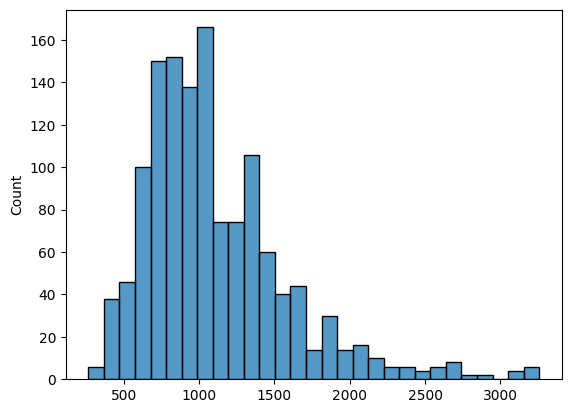

In [22]:
from tqdm.notebook import tqdm
import seaborn as sns

res = []
for x in tqdm(dataset['chosen']):
    res.append(len(tokenizer.encode(x)))

print(len([x for x in res if x>max_seq_length]))
sns.histplot(res)

  0%|          | 0/1322 [00:00<?, ?it/s]

0


<Axes: ylabel='Count'>

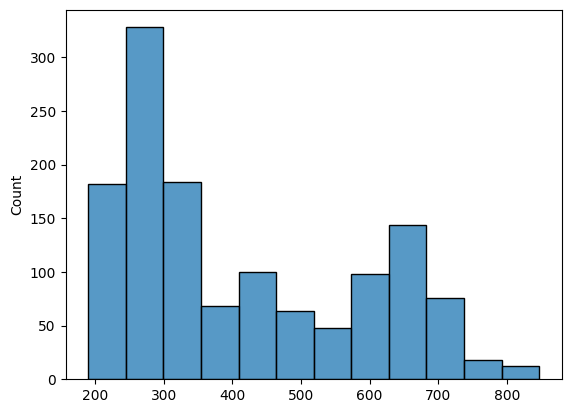

In [23]:
res2 = []
for x in tqdm(dataset['rejected']):
    res2.append(len(tokenizer.encode(x)))

print(len([x for x in res2 if x>max_seq_length]))
sns.histplot(res2)

  0%|          | 0/1322 [00:00<?, ?it/s]

0


<Axes: ylabel='Count'>

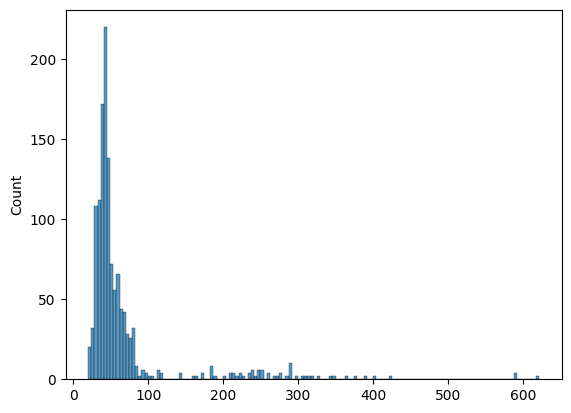

In [24]:
res3 = []
for x in tqdm(dataset['prompt']):
    res3.append(len(tokenizer.encode(x)))

print(len([x for x in res3 if x>max_seq_length]))
sns.histplot(res3)

## DPO 학습

In [ ]:
import os
import requests

# 고정 설정
os.environ['WANDB_PROJECT']="krx"
os.environ['WANDB_API_KEY']="****"
os.environ['WANDB_ENTITY']="****"

# 개별 설정
os.environ['WANDB_TAGS']=""
run_name = ""

In [26]:
from transformers import TrainingArguments
from trl import DPOTrainer, DPOConfig
from unsloth import is_bfloat16_supported
import requests

dpo_trainer = DPOTrainer(
    model = model,
    ref_model = None,
    args = DPOConfig(
        per_device_train_batch_size = 4,
        gradient_accumulation_steps = 2,
        warmup_ratio = 0.1,
        num_train_epochs = 1,
        learning_rate = 5e-6,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_hf",
        weight_decay = 0.0,
        lr_scheduler_type = "linear",
        seed = 777,
        output_dir = "outputs_dpo",
        save_strategy = "no",
        # save_steps = 1000,
        # save_total_limit = 2,
        # report_to = "none", # Use this for WandB etc
        report_to = "wandb",
        run_name = run_name,
    ),
    beta = 0.1,
    train_dataset = dataset,
    # eval_dataset = dataset["test"],
    tokenizer = tokenizer,
    max_length = max_seq_length,
    max_prompt_length = 512,
)

Extracting prompt from train dataset:   0%|          | 0/1322 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/1322 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1322 [00:00<?, ? examples/s]

In [ ]:
try:
    trainer_stats = dpo_trainer.train()
except Exception as e:
    print(e)
    

In [ ]:
import wandb
# wandb 로깅 종료
wandb.finish()

## 모델 저장

In [ ]:
# # LoRA Adapter 저장
# model.save_pretrained("lora_model")
# tokenizer.save_pretrained("lora_model")

In [29]:
# # Merged model 저장
local_model_save_path = "sft-v7.1-prc-dpo"
model.save_pretrained_merged(local_model_save_path, tokenizer, save_method = "merged_16bit",)

Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 611.34 out of 1007.38 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 28/28 [00:00<00:00, 87.38it/s]


Unsloth: Saving tokenizer... Done.
Done.


## 모델 추론 및 업로드

In [21]:
FastLanguageModel.for_inference(model)

qq = '''\
### 질문: 우리나라의 사회보장제도 운영에 관한 설명으로 옳은 것은?

### 선택지:
A. 차상위계층이라 함은 소득이 최저생계비 130% 이하인 가구를 말한다.
B. 기초연금제도 운영에 필요한 재원은 국민연금 보험료로 충당한다.
C. 국민기초생활보장제도 수급자로서 급여를 받기 위해서는 부양의무자가 없거나 있어도 부양이 불가능하여야 하며, 자산조사 결과 최저생계비 이하이어야 한다.
D. 사업장(직장)가입자의 모든 사회보험료는 고용주와 근로자가 각각 절반씩 분담한다.
E. 건강보험제도 운영에 필요한 재원은 가입자 및 사용자로부터 징수한 보험료와 정부지원금으로 충당한다.
'''

inputs = tokenizer(
[
    qq,
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 1024, use_cache = True)
print(tokenizer.batch_decode(outputs)[0])

### 질문: 우리나라의 사회보장제도 운영에 관한 설명으로 옳은 것은?

### 선택지:
A. 차상위계층이라 함은 소득이 최저생계비 130% 이하인 가구를 말한다.
B. 기초연금제도 운영에 필요한 재원은 국민연금 보험료로 충당한다.
C. 국민기초생활보장제도 수급자로서 급여를 받기 위해서는 부양의무자가 없거나 있어도 부양이 불가능하여야 하며, 자산조사 결과 최저생계비 이하이어야 한다.
D. 사업장(직장)가입자의 모든 사회보험료는 고용주와 근로자가 각각 절반씩 분담한다.
E. 건강보험제도 운영에 필요한 재원은 가입자 및 사용자로부터 징수한 보험료와 정부지원금으로 충당한다.
F. 국민연금제도 운영에 필요한 재원은 국민연금 보험료로 충당한다.
G. 국민연금제도는 국민의 노후 생활을 보장하기 위해 설립된 제도로, 국민의 노후 생활을 보장하기 위해 설립된 제도이다.
H. 국민연금제도는 국민의 노후 생활을 보장하기 위해 설립된 제도로, 국민의 노후 생활을 보장하기 위해 설립된 제도이다.

### 정답: 먼저 차근차근 한 단계씩 생각해봅시다.

#### step1. 문제 이해:
문제는 우리나라의 사회보장제도 운영에 관한 설명 중 옳은 것을 찾는 것입니다. 각 보기에서 제시된 설명이 실제 사회보장제도의 운영 방식과 일치하는지를 판단해야 합니다. 문제 해결을 위해 각 보기를 독립적으로 검토하고, 관련 법령이나 제도의 내용을 바탕으로옳은 설명을 선택해야 합니다.

#### step2. 각 보기별 문제 풀이:
A. 차상위계층이라 함은 소득이 최저생계비 130% 이하인 가구를 말한다. - 이 설명은 정확하지 않습니다. 차상위계층은 일반적으로 최저생계비의 150% 이하인 가구를 의미합니다.
B. 기초연금제도 운영에 필요한 재원은 국민연금 보험료로 충당한다. - 이 설명은 틀렸습니다. 기초연금은 국민연금과는 복합적으로 운영되며, 재원은 국민연금 보험료뿐만 아니라 정부의 예산 지원도 포함됩니다.
C. 국민기초생활보장제도 수급자로서 급여를 받기 위해서는 부양의무자가 없거나 있어도 부양이 불

In [20]:
# qq = "현재 주가는 50달러, 무위험이자율은 연 10%, 변동성은 연 30%이며, 만기가 3개월인 유러피언 풋옵션의 가격을 계산하시오."
qq = "주가가 기대수익률 16%, 변동성 35%를 따르는 기하 브라운 운동을 할 때, 만기 6개월, 행사가격 40달러인 유러피언 콜옵션과 풋옵션의 행사 가능성을 계산하시오."
# qq = "두 숫자 $90$과 $m$은 정확히 3개의 양의 제수를 공유합니다. 이 세 가지 공통 제수 중 가장 큰 제수는 무엇일까요?"

inputs = tokenizer(
[
    qq,
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 1024, use_cache = True)
print(tokenizer.batch_decode(outputs)[0])

주가가 기대수익률 16%, 변동성 35%를 따르는 기하 브라운 운동을 할 때, 만기 6개월, 행사가격 40달러인 유러피언 콜옵션과 풋옵션의 행사 가능성을 계산하시오. 이때, 현재 주가는 40달러이며, 연간 무위험 이자율은 5%입니다.

주어진 조건을 바탕으로 유러피언 콜옵션과 풋옵션의 행사 가능성을 계산해보겠습니다.

### 주어진 조건:
- **현재 주가 (S₀):** 40달러
- **행사가격 (K):** 40달러
- **기대수익률 (μ):** 16% (연간)
- **변동성 (σ):** 35% (연간)
- **만기 (T):** 6개월 (0.5년)
- **무위험 이자율 (r):** 5% (연간)

### 1. Black-Scholes 모델 적용

Black-Scholes 모델을 사용하여 콜옵션과 풋옵션의 가격을 계산할 수 있습니다. 이 모델은 다음과 같은 공식을 사용합니다:

\[
C = S_0 N(d_1) - K e^{-rT} N(d_2)
\]
\[
P = K e^{-rT} N(-d_2) - S_0 N(-d_1)
\]

여기서,

\[
d_1 = \frac{\ln(\frac{S_0}{K}) + (r + \frac{\sigma^2}{2})t}{\sigma \sqrt{t}}
\]
\[
d_2 = d_1 - \sigma \sqrt{t}
\]

### 2. 계산 단계

#### (a) \( d_1 \)과 \( d_2 \) 계산

\[
d_1 = \frac{\ln(\frac{40}{40}) + (0.05 + \frac{0.35^2}{2}) \times 0.5}{0.35 \times \sqrt{0.5}} = \frac{0 + (0.05 + 0.030625) \times 0.5}{0.35 \times 0.7071} = \frac{0.0453125}{0.254985} \approx 0.1778
\]

\[
d_2 = d_1 - 0.35 \times 0.7071 \approx 0.1778 - 0.2475 \approx -0.0697
\]

#### (b) 정규 분포 함수 \

In [20]:
# del model
# torch.cuda.empty_cache()